In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [4]:
from IPython.display import clear_output

In [5]:
import pickle

In [6]:
sys.path.append("../../../Scripts/")

In [7]:
import utils as gb_utils

In [8]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'1.15.0'

In [9]:
import kerastuner as kt

ModuleNotFoundError: No module named 'kerastuner'

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8628326003130731493
]


In [11]:
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

In [101]:
if float(tf.__version__[:3]) > 2.0:
    assert(tf.config.list_physical_devices('GPU'))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [13]:
def find_min_max(X):
    return np.min(X), np.max(X)

In [14]:
# load and process the datasets
def load_data_with_preprocessing(data_path):
    f = open(data_path, "rb")
    x, y = pickle.load(f)
    f.close()
    
    if len(x) != len(y):
        raise ValueError("Unequal X and Y sizes")
        return
    
#     print(x.shape, y.shape)
#     wherenane = np.argwhere(np.isnan(x))[:, 1]
#     print(np.unique(wherenane, return_counts=True))
    # do we need preprocessing 
    print("Before Sacling: Min - Max {}".format(find_min_max(x)))
    scaler = MinMaxScaler((-1.0, 1.0))
    x = scaler.fit_transform(x)
    print("After Scaling: Min - Max {}".format(find_min_max(x)))
    
    return x, y
#     return train_test_split(x, y, stratify=y, random_state = 24, shuffle = True, 
#                                                    test_size = 0.25)

In [15]:
os.listdir("../Processed data/")

['adl_activity_dataset.pickle',
 'adl_activity_dataset_small.pickle',
 'adl_activity_dataset_small_minmax_scaled.pickle',
 'adl_activity_feature_dataset_small.pickle',
 'adl_dataset_small_minmax_scaled_feature.pickle',
 'adl_posture_data.pickle',
 'adl_posture_dataset.pickle',
 'adl_posture_dataset_small.pickle',
 'adl_posture_feature_dataset.pickle',
 'adl_posture_feature_dataset_1.pickle',
 'mHealth_ankle_dataset.pickle',
 'mHealth_ankle_feature_dataset.pickle',
 'mHealth_chest_dataset.pickle',
 'mHealth_chest_feature_dataset.pickle',
 'mHealth_wrist_dataset.pickle',
 'mHealth_wrist_feature_dataset.pickle',
 'mHealth_wrist_feature_dataset_1.pickle',
 'uci_body_acc_dataset.pickle',
 'uci_feature_dataset.pickle',
 'uci_feature_dataset_1.pickle']

In [69]:
data_path = "../Processed data/adl_posture_feature_dataset.pickle"

In [70]:
X, Y = load_data_with_preprocessing(data_path)

Before Sacling: Min - Max (-5678.34731218833, 87555.07918323368)
After Scaling: Min - Max (-1.0, 1.0000000000000004)


In [71]:
np.unique(Y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([2739, 2739, 2739, 2739, 2739, 2739], dtype=int64))

In [59]:
indexes = np.where(Y != 11)[0]
X = X[indexes]
Y = Y[indexes]

In [60]:
np.unique(Y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([460, 460, 460, 460, 460, 426, 444, 441, 460, 460, 460], dtype=int64))

In [72]:
x_train, x_val, x_test, y_train, y_val, y_test = gb_utils.split_into_train_val_test(X, Y)

Training set (11092, 45) 
Test set (4109, 45)
Validation set (1233, 45)


In [73]:
y_train_hot = gb_utils.get_hot_labels(y_train)
y_val_hot = gb_utils.get_hot_labels(y_val)
y_test_hot = gb_utils.get_hot_labels(y_test)

n_classes = np.max(y_train) + 1

In [74]:
learning_rate = 0.001
n_channels = 3

TRAIN_SIZE, input_len = x_train.shape
TEST_SIZE, _ = x_test.shape

BATCH_SIZE = 32
N_EPOCHS = 200
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

In [75]:
n_classes, input_len, STEPS_PER_EPOCH

(6, 45, 346)

In [77]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate = learning_rate,
    decay_steps=STEPS_PER_EPOCH * 10,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [146]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
        clear_output(wait = True)

In [25]:
def train_model(model, batch_size, epochs):
    plot_losses = gb_utils.PlotLosses()
    
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, min_delta = 0.01, 
                                                  verbose = 1, mode = 'min')
    callbacks = [plot_losses]
    
    history = model.fit(x_train, y_train_hot, batch_size = batch_size, epochs = epochs, 
                        validation_data = (x_val, y_val_hot), verbose = 0, callbacks = callbacks)

In [26]:
def get_dnn_model():
    t_input = tf.keras.Input(shape=(input_len, ))
    t_x = keras.layers.Dense(units = 128, activation = tf.nn.relu)(t_input)
    t_x = keras.layers.Dropout(0.3)(t_x)
    t_x = keras.layers.Dense(units = 128, activation = tf.nn.relu)(t_x)
    t_output = keras.layers.Dense(units = n_classes, activation = tf.nn.softmax)(t_x)
    
    t_model = tf.keras.Model(inputs = t_input, outputs=t_output)    
    t_model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
        metrics = ['accuracy'])
    
    return t_model

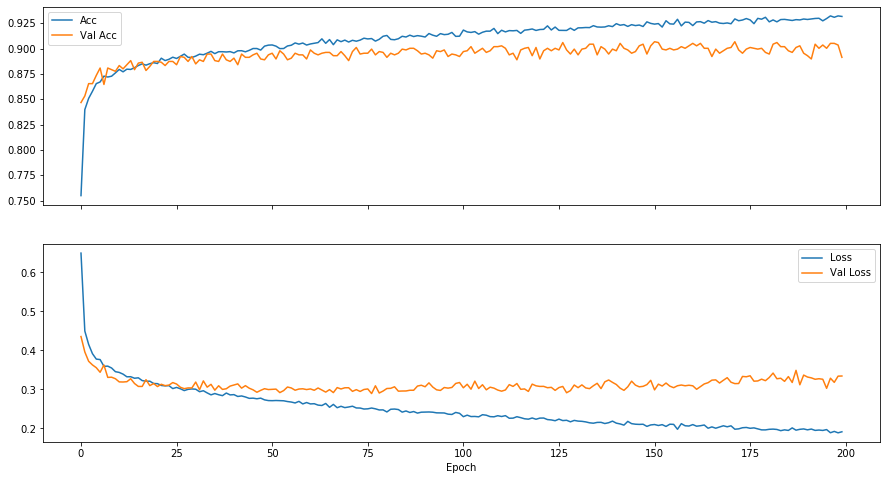

In [76]:
model = get_dnn_model()
train_model(model, BATCH_SIZE, N_EPOCHS)

In [79]:
model.evaluate(x_train, y_train_hot)

11092/11092 [==============================] - 0s 20us/sample - loss: 0.1499 - acc: 0.9475


[0.14986322926585097, 0.94752973]

In [80]:
model.evaluate(x_test, y_test_hot)

4109/4109 [==============================] - 0s 20us/sample - loss: 0.3389 - acc: 0.8983


[0.3389221850023794, 0.8982721]

In [81]:
os.listdir("../Saved Model/")

['adl_activity_segment_model.h5py',
 'adl_posture_segment_model.h5py',
 'mh_ankle_feature_model',
 'mh_ankle_segment_model.h5py',
 'mh_chest_feature_model',
 'mh_chest_segment_model.h5py',
 'mh_wrist_feature_model',
 'mh_wrist_segment_model.h5py',
 'uci_feature_model',
 'uci_segment_model.h5py']

In [82]:
model.save('../Saved Model/adl_posture_feature_model')

# Keras Hyperparameter Tuner

In [73]:
def get_adl_tuner_model(hp):
    t_input = tf.keras.Input(shape=(input_len, ))
    
    # Tune the number of units in all dense layers
    # Choose an optimal value between 32 - 1024
    hp_units_d1 = hp.Int('d1_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units = hp_units_d1, activation = tf.nn.relu)(t_input)
    
    hp_units_d2 = hp.Int('d2_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units = hp_units_d2, activation = tf.nn.relu)(t_x)
    
    hp_units_d3 = hp.Int('d3_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units = hp_units_d3, activation = tf.nn.relu)(t_x)
    
    hp_units_d4 = hp.Int('d4_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units = hp_units_d4, activation = tf.nn.relu)(t_x)
    
    t_output = keras.layers.Dense(units = n_classes, activation = tf.nn.softmax)(t_x)

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    t_model = tf.keras.Model(inputs = t_input, outputs=t_output)    
    t_model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), 
        metrics = ['accuracy'])
    
    return t_model
    

In [74]:
"""
If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. 
To disable this behavior, pass an additional overwrite = True argument while instantiating the tuner.
"""
tuner = kt.Hyperband(get_adl_tuner_model,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'hyparameter_tuner_logs',
                     project_name = 'adl_activity_tuner',
                     seed=42
                    )   

In [75]:
tuner.search_space_summary()

In [77]:
tuner.search(x_train, y_train_hot, epochs = 10, 
             validation_data = (x_val, y_val_hot), 
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [78]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('d1_units')}. The optimal number of units in the second densely-connected
layer is {best_hps.get('d2_units')}. The optimal number of units in the third densely-connected
layer is {best_hps.get('d3_units')}. The optimal number of units in the fourth densely-connected
layer is {best_hps.get('d4_units')}. The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32. The optimal number of units in the second densely-connected
layer is 128. The optimal number of units in the third densely-connected
layer is 96. The optimal number of units in the fourth densely-connected
layer is 96. The optimal learning rate is 0.001.



In [80]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test_hot)
print(loss, accuracy)

1239/1239 [==============================] - ETA: 1s - loss: 1.0092 - accuracy: 0.59 - ETA: 2s - loss: 1.3801 - accuracy: 0.50 - ETA: 2s - loss: 1.3742 - accuracy: 0.49 - ETA: 2s - loss: 1.3673 - accuracy: 0.50 - ETA: 2s - loss: 1.3707 - accuracy: 0.49 - ETA: 2s - loss: 1.3731 - accuracy: 0.49 - ETA: 2s - loss: 1.3839 - accuracy: 0.49 - ETA: 2s - loss: 1.3864 - accuracy: 0.49 - ETA: 2s - loss: 1.3742 - accuracy: 0.50 - ETA: 2s - loss: 1.3744 - accuracy: 0.50 - ETA: 2s - loss: 1.3756 - accuracy: 0.50 - ETA: 1s - loss: 1.3784 - accuracy: 0.50 - ETA: 1s - loss: 1.3816 - accuracy: 0.50 - ETA: 1s - loss: 1.3805 - accuracy: 0.50 - ETA: 1s - loss: 1.3822 - accuracy: 0.50 - ETA: 1s - loss: 1.3844 - accuracy: 0.50 - ETA: 1s - loss: 1.3824 - accuracy: 0.50 - ETA: 1s - loss: 1.3841 - accuracy: 0.50 - ETA: 1s - loss: 1.3849 - accuracy: 0.50 - ETA: 1s - loss: 1.3846 - accuracy: 0.50 - ETA: 1s - loss: 1.3846 - accuracy: 0.50 - ETA: 1s - loss: 1.3812 - accuracy: 0.50 - ETA: 1s - loss: 1.3804 - accura

# ADL Model based on Tuned values

In [35]:
L2_REG_COEFF = 0.001

In [49]:
def get_adl_dnn_model():
    t_input = tf.keras.Input(shape=(input_len, ))
    t_x = keras.layers.Dense(units = 96, activation = tf.nn.relu)(t_input)
#     t_x = keras.layers.Dropout(0.5)(t_x)
    t_x = keras.layers.Dense(units = 512, activation = tf.nn.relu)(t_x)
    
    t_x = keras.layers.Dense(units = 512, activation = tf.nn.relu)(t_x)
    
    t_x = keras.layers.Dense(units = 512, activation = tf.nn.relu)(t_x)
    
    t_x = keras.layers.Dense(units = 512, activation = tf.nn.relu,
                            kernel_regularizer=keras.regularizers.L2(L2_REG_COEFF))(t_x)

    t_x = keras.layers.Dense(units = 256, activation = tf.nn.relu,
                            kernel_regularizer=keras.regularizers.L2(L2_REG_COEFF))(t_x)

    t_x = keras.layers.Dense(units = 256, activation = tf.nn.relu,
                            kernel_regularizer=keras.regularizers.L2(L2_REG_COEFF))(t_x)
    
    t_output = keras.layers.Dense(units = n_classes, activation = tf.nn.softmax)(t_x)

    t_model = tf.keras.Model(inputs = t_input, outputs=t_output)    
    t_model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics = ['accuracy'])
    
    return t_model

# Feature Model for UCI

In [124]:
def get_uci_tuner_model(hp):
    t_input = tf.keras.Input(shape=(input_len, ))
    # Choose an optimal value between 32 - 128
    hp_units_d1 = hp.Int('d1_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units = hp_units_d1, activation = tf.nn.relu)(t_input)
    
    # Choose an optimal value between 32 - 128
    hp_units_d1 = hp.Int('d2_units', min_value=32, max_value=128, step = 32)
    t_x = keras.layers.Dense(units=hp_units_d1, activation = tf.nn.relu)(t_x)
    
    t_output = keras.layers.Dense(units = n_classes, activation = tf.nn.softmax)(t_x)
    t_model = tf.keras.Model(inputs = t_input, outputs=t_output)    
    
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    t_model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        metrics = ['accuracy'])
    
    return t_model

In [125]:
"""
If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these 
logs to resume the search. 
To disable this behavior, pass an additional overwrite = True argument 
while instantiating the tuner.
"""
tuner = kt.Hyperband(get_uci_tuner_model,
                     objective = 'val_accuracy', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'hyparameter_tuner_logs',
                     project_name = 'uci_dnn_feature_model',
                     seed=42
                    )

In [126]:
tuner.search_space_summary()

In [127]:
tuner.search(x_train, y_train_hot, epochs = 10, 
             validation_data = (x_val, y_val_hot), 
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [128]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('d1_units')}. The optimal number of units in the second densely-connected
layer is {best_hps.get('d2_units')}. The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128. The optimal number of units in the second densely-connected
layer is 128. The optimal learning rate is 0.001.



In [129]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test_hot)

81/81 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.75 - ETA: 0s - loss: 0.5852 - accuracy: 0.68 - ETA: 0s - loss: 0.6123 - accuracy: 0.68 - 0s 2ms/step - loss: 0.6029 - accuracy: 0.6850


In [130]:
print(loss, accuracy)

0.6028878092765808 0.685048520565033
